# Lecture 3

## Inverting Image Representations of Pre-trained CNNs

In preperation for this lecture we read the paper:  
[_'Understanding Deep Image Representations by Inverting Them', Mahendran and Vedaldi, 2014_](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Mahendran_Understanding_Deep_Image_2015_CVPR_paper.pdf).  
Here we want to implement their method to invert image representations of pre-trained CNNs.  
We will use PyTorch, for more information and tutorials on PyTorch checkout:  
http://pytorch.org/docs/  
http://pytorch.org/tutorials/

In [1]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
#alexnet definition that conveniently let's you grab the outputs from any layer. 
#Also we ignore dropout here
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        #convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #pooling layers
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
        #fully connected layers
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        
    def forward(self, x, out_keys):
        out = {}
        out['c1'] = self.conv1(x)
        out['r1'] = F.relu(out['c1'])
        out['p1'] = self.pool1(out['r1'])
        out['r2'] = F.relu(self.conv2(out['p1']))
        out['p2'] = self.pool2(out['r2'])
        out['r3'] = F.relu(self.conv3(out['p2']))
        out['r4'] = F.relu(self.conv4(out['r3']))
        out['r5'] = F.relu(self.conv5(out['r4']))
        out['p3'] = self.pool3(out['r5'])
        out['fc1'] = F.relu(self.fc1(out['p3'].view(1, -1)))
        out['fc2'] = F.relu(self.fc2(out['fc1']))
        out['fc3'] = self.fc3(out['fc2'])
        return [out[key] for key in out_keys]

In [3]:
#load alexnet weights
model_dir = pj(os.path.dirname(cwd),'Lecture2')
model_file_name = 'alexnet-owt-4df8aa71.pth'
alexnet_weights = torch.load(pj(model_dir, model_file_name))
#load pretrained weights into the new model definition
alexnet = AlexNet()
keys = alexnet.state_dict().keys()
myalexnet_weights = {}
for k, key in enumerate(alexnet_weights.keys()):
    myalexnet_weights[keys[k]] = alexnet_weights[key]
alexnet.load_state_dict(myalexnet_weights)
alexnet.eval()

AlexNet (
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (pool2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (pool3): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (9216 -> 4096)
  (fc2): Linear (4096 -> 4096)
  (fc3): Linear (4096 -> 1000)
)

In [4]:
# define pre and post processing for images using the torchvision helper functions
img_size = 224
prep = transforms.Compose([
        transforms.Scale((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
postpa = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
    ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor.clone())
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

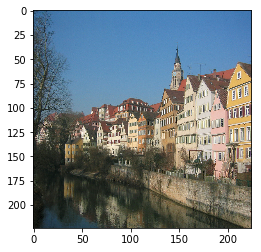

[torch.Size([1, 64, 55, 55]), torch.Size([1, 256, 13, 13])]


In [5]:
#get image
img_dir = pj(os.path.dirname(cwd), 'Lecture1')
img_name = 'Tuebingen_Neckarfront.jpg'
img = Image.open(pj(img_dir, img_name))
#preprocess image
img_torch = Variable(prep(img).unsqueeze(0), requires_grad=False)
#show preprocessed image, dimensions are now 224x224 since this is what the network was trained on
imshow(postp(img_torch.data.squeeze()));show()

#now you can easily get the response of different layers in the network by passing a list of keys
out_layer = ['r1', 'r5']
out = alexnet(img_torch, out_layer)
#print the representation size for each output layer
print([o.size() for o in out])

## Assignment for next week
Use above network to reproduce the results from [_'Understanding Deep Image Representations by Inverting Them', Mahendran and Vedaldi, 2014_](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Mahendran_Understanding_Deep_Image_2015_CVPR_paper.pdf): reconstruct a natural image from different feature representations in AlexNet.